In [39]:
# For this project, we will be using the following libraries
import pandas as pd

# For data visualization, we will be using the following libraries
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud


# algebra
import numpy as np

# text processing

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

# ML libraries

## sklearn

# preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, RobustScaler, Normalizer

# models
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
# xgboost
from xgboost import XGBClassifier

# multiclass
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

import warnings
warnings.filterwarnings("ignore")
import string
sns.set_style("dark")

# Data set

In [3]:
train_data = pd.read_csv(
    "/home/ahmed/Ai/Data science and Ml projects/Emotion-Detection/Data set/train.txt",
    sep=";",
    header=None,
    names=["text", "emotion"],
)
test_data = pd.read_csv(
    "/home/ahmed/Ai/Data science and Ml projects/Emotion-Detection/Data set/test.txt",
    sep=";",
    header=None,
    names=["text", "emotion"],
)
validation_data = pd.read_csv(
    "/home/ahmed/Ai/Data science and Ml projects/Emotion-Detection/Data set/val.txt",
    sep=";",
    header=None,
    names=["text", "emotion"],
)

In [4]:
print("Test Data\n ", test_data.head(5))
print(
    "---------------------------------------------------------------------------------"
)
print("Train Data\n", train_data.head(5))
print(
    "---------------------------------------------------------------------------------"
)
print("Validation Data\n", validation_data.head(5))

Test Data
                                                  text  emotion
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness
---------------------------------------------------------------------------------
Train Data
                                                 text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
---------------------------------------------------------------------------------
Validation Data
                                                 tex

# EDA

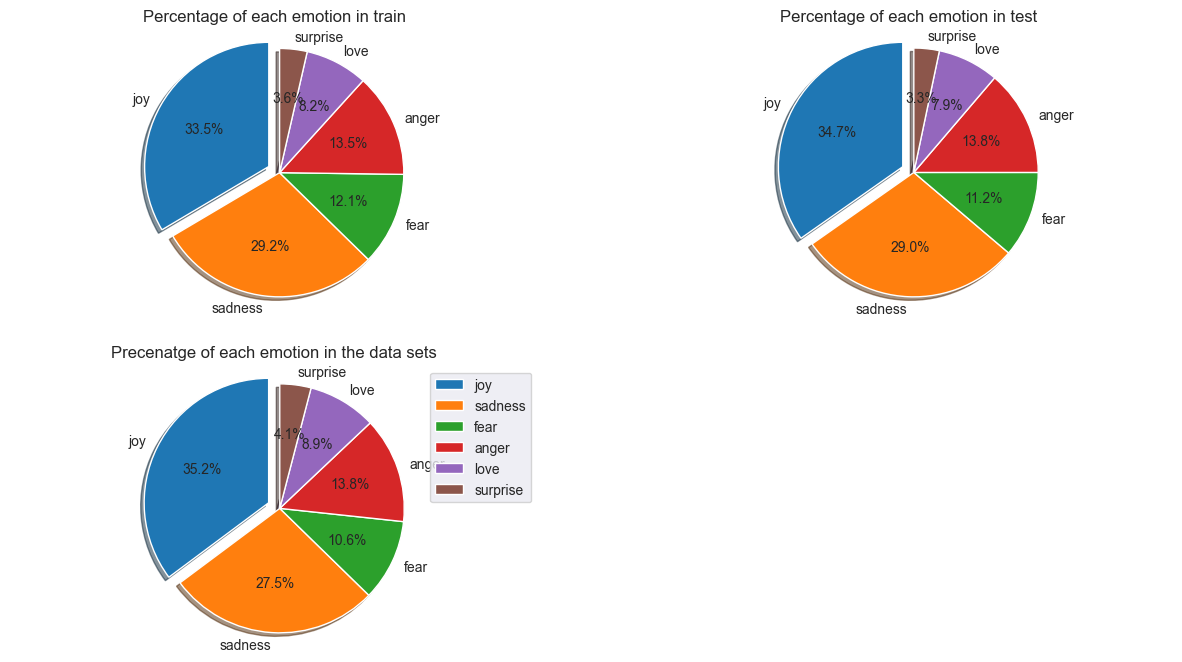

In [5]:
def pie_chart():
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    combin = [train_data, test_data, validation_data]
    fig1, ax1 = plt.subplots(2, 2, figsize=(15, 8))
    for i, data_set in enumerate(combin):
        labels = "joy", "sadness", "fear", "anger", "love", "surprise"
        sizes = [data_set.emotion.value_counts()[i] for i in labels]
        explode = (0.1, 0, 0, 0, 0, 0)  # only "explode" the 1st slice (i.e. 'joy')
        row = i // 2
        col = i % 2
        ax1[row, col].pie(
            sizes,
            explode=explode,
            labels=labels,
            autopct="%1.1f%%",
            shadow=True,
            startangle=90,
        )
        name = "train" if i == 0 else "test" if i == 1 else "validation"
        ax1[row, col].set_title(f"Percentage of each emotion in {name}")
        ax1[row, col].axis(
            "equal"
        )  # Equal aspect ratio ensures that pie is drawn as a circle.
    ax1[1, 1].remove()
    plt.title("Precenatge of each emotion in the data sets")
    plt.legend()
    plt.show()


pie_chart()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


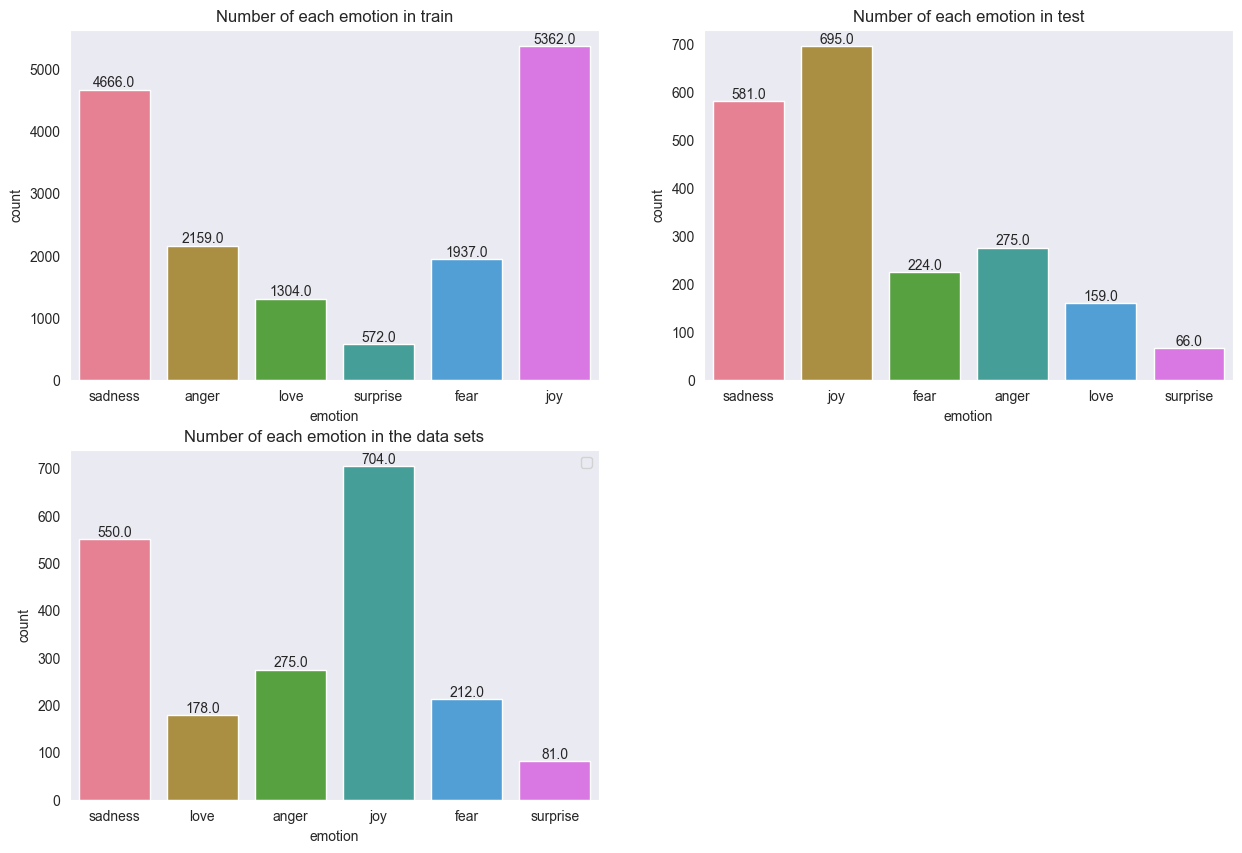

In [140]:
def bar_char():
    combin = [train_data, test_data, validation_data]
    fig1, ax1 = plt.subplots(2, 2, figsize=(15, 10))

    for i, data_set in enumerate(combin):
        row = i // 2
        col = i % 2
        palette = sns.color_palette("husl", 6)
        sns.countplot(data=data_set, x="emotion", palette=palette, ax=ax1[row, col])
        name = "train" if i == 0 else "test" if i == 1 else "validation"
        ax1[row, col].set_title(f"Number of each emotion in {name}")

        # disply number of each emotion
        for p in ax1[row, col].patches:
            ax1[row, col].annotate(
                f"{p.get_height()}",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center",
                va="center",
                xytext=(0, 5),
                textcoords="offset points",
            )

    ax1[1, 1].remove()
    plt.title("Number of each emotion in the data sets")
    plt.legend()
    plt.show()


bar_char()

# Text Preprocessing

In [6]:
class text_processing(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        lower=False,
        upper=False,
        remove_special_characters=False,
        remove_punctuation=False,
        remove_stop_words=False,
        stem_the_words=False,
    ) -> None:
        self.lower = lower
        self.upper = upper
        self.remove_special_characters = remove_special_characters
        self.remove_punctuation = remove_punctuation
        self.remove_stop_words = remove_stop_words
        self.stem_the_words = stem_the_words
        super().__init__()

    def fit(self, X, y=None):
        return self

    # for converting the text to lower case
    def __convert_text_lower(self, text):
        text = text.lower()
        return text

    def __lower_text(self, X):
        X = X.apply(self.__convert_text_lower)
        return X

    # for converting the text to upper case
    def __convert_text_upper(self, text):
        text = text.upper()
        return text

    def __upper_text(self, X):
        X = X.apply(self.__convert_text_upper)
        return X

    # for converting the text to words
    def __TextToWord(self, X):
        words = word_tokenize(X)
        return words

    # for removing Special Characters
    """    
        First we need to convert the text to words
        Then we will remove the special characters
        We will use the isalnum() method to check if the word is alphanumeric
        At the end we will join the words to form a text
    """

    def __remove_spec(self, X):
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if w.isalnum():
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Special_Characters(self, X):
        X = X.apply(self.__remove_spec)
        return X

    # for removing Punctuation
    """
        First we need to convert the text to words
        Then we will remove the punctuation
        We will use the string.punctuation to get all the punctuation
        At the end we will join the words to form a text
    """

    def __remove_puncs(self, X):
        words = self.__TextToWord(X)
        punctuation = set(string.punctuation)
        fixed_words = []
        for w in words:
            if not punctuation.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_Punctuation(self, X):
        X = X.apply(self.__remove_puncs)
        return X

    # for removing Stop Words
    """
        First we need to convert the text to words
        Then we will remove the stop words
        We will use the nltk stopwords to get all the stop words
        At the end we will join the words to form a text
    """

    def __remove_stop(self, X):
        stop_words = set(stopwords.words("english"))
        words = self.__TextToWord(X)
        fixed_words = []
        for w in words:
            if not stop_words.__contains__(w):
                fixed_words.append(w)
        return " ".join(fixed_words)

    def __Remove_stop_words(self, X):
        X = X.apply(self.__remove_stop)
        return X

    # for Stemming the words
    """
    First we need to convert the text to words
    Then we will stem the words
    We will use the PorterStemmer to stem the words
    At the end we will join the words to form a text    
    """

    def __stem_text(self, text):
        stemmer = PorterStemmer()
        words = self.__TextToWord(text)
        stemmed_words = []
        for w in words:
            stemmed_words.append(stemmer.stem(w))
        return " ".join(stemmed_words)

    def __Stemming(self, X):
        X = X.apply(self.__stem_text)
        return X

    # we will apply the text processing based on the parameters
    def process_text(self, X):
        data = X.copy()
        # will lowercase the text
        if self.lower:
            data = self.__lower_text(data)
        # will uppercase the text
        if self.upper:
            data = self.__upper_text(data)
        # will remove the special characters
        if self.remove_special_characters:
            data = self.__Remove_Special_Characters(data)
        # will remove the punctuation
        if self.remove_punctuation:
            data = self.__Remove_Punctuation(data)
        # will remove the stop words
        if self.remove_stop_words:
            data = self.__Remove_stop_words(data)
        # will stem the words
        if self.stem_the_words:
            data = self.__Stemming(data)
        return data

    def transform(self, X, y=None):
        return self.process_text(X)

In [7]:
# removig Duplicate data
combine = [train_data, test_data, validation_data]
for data_set in combine:
    print(data_set.duplicated().sum())
print(
    "---------------------------------------------------------------------------------"
)
for data_set in combine:
    data_set.drop_duplicates(inplace=True)
    print(data_set.duplicated().sum())

1
0
0
---------------------------------------------------------------------------------
0
0
0


# Spliting data

In [8]:
train_x_train = train_data.text
train_y_train = train_data.emotion

test_x_test = test_data.text
test_y_test = test_data.emotion

validation_x_val = validation_data.text
validation_y_val = validation_data.emotion

In [9]:
label_encoder = LabelEncoder()
train_y_train = label_encoder.fit_transform(train_y_train)
test_y_test = label_encoder.transform(test_y_test)
validation_y_val = label_encoder.transform(validation_y_val)

In [158]:
label_encoder.classes_ 

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

# Models

*    MultinomialNB
*    RandomForestClassifier
*    XGBClassifier
*    SCV
*    VotingClassifier

In [160]:
def acc_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


def conf_mat(model,train_x_train_processed, test_x_test_processed, validation_x_val_processed):
    pipeline_train_pred = model.predict(train_x_train_processed)
    pipeline_test_pred = model.predict(test_x_test_processed)
    pipeline_val_pred = model.predict(validation_x_val_processed)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    cm = confusion_matrix(list(train_y_train), list(pipeline_train_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[0],
        fmt="d",
        cmap="Blues",
    )
    ax[0].set_title("Train Data")
    ax[0].set_xlabel("Predicted Labels")
    ax[0].set_ylabel("True Labels")

    cm = confusion_matrix(list(test_y_test), list(pipeline_test_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[1],
        fmt="d",
        cmap="Blues",
    )
    ax[1].set_title("Test Data")
    ax[1].set_xlabel("Predicted Labels")
    ax[1].set_ylabel("True Labels")

    cm = confusion_matrix(list(validation_y_val), list(pipeline_val_pred))
    sns.heatmap(
        cm,
        annot=True,
        ax=ax[2],
        fmt="d",
        cmap="Blues",
    )
    ax[2].set_title("Validation Data")
    ax[2].set_xlabel("Predicted Labels")
    ax[2].set_ylabel("True Labels")
    plt.legend()
    plt.show()

In [161]:
# multinomial naive bayes
"""
    Steps:
    1. Text Processing
    2. Vectorization by using CountVectorizer for converting the text to numbers
    3. Training the model by using Pipeline       
"""

text_processing_odj = text_processing(
    lower=True,
    remove_special_characters=True,
    remove_punctuation=False,
    remove_stop_words=False,
    stem_the_words=False,
)

process_pip = Pipeline(
    [
        ("text_processing", text_processing_odj),
    ]
)

vectorizer = CountVectorizer(max_features=3000)
MNB = MultinomialNB()
scaler = StandardScaler()
MNB_pipeline = Pipeline(
    [
        ("text_processing", text_processing_odj),
        ("vectorizer", vectorizer),
        ("MNB", MNB),
    ]
)
oneVone = OneVsOneClassifier(MNB_pipeline)
oneVall = OneVsRestClassifier(MNB_pipeline)

oneVall.fit(train_x_train, train_y_train)
# oneVone.fit(train_x_train, train_y_train)

OneVsRestClassifier(estimator=Pipeline(steps=[('text_processing',
                                               text_processing(lower=True,
                                                               remove_special_characters=True)),
                                              ('vectorizer',
                                               CountVectorizer(max_features=3000)),
                                              ('MNB', MultinomialNB())]))

In [162]:
process_pip = Pipeline(
    [
        ("text_processing", text_processing_odj),
    ]
)
train_x_train_processed = process_pip.fit_transform(train_x_train)
test_x_test_processed = process_pip.transform(test_x_test)
validation_x_val_processed = process_pip.transform(validation_x_val)


In [163]:
# validation by using the accuracy score, confusion matrix, and classification report

print("One vs All")
print(acc_score(train_y_train, oneVall.predict(train_x_train_processed)))
print(acc_score(test_y_test, oneVall.predict(test_x_test_processed)))
print(acc_score(validation_y_val, oneVall.predict(validation_x_val_processed)))

One vs All
0.9290580661291331
0.87
0.8765


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


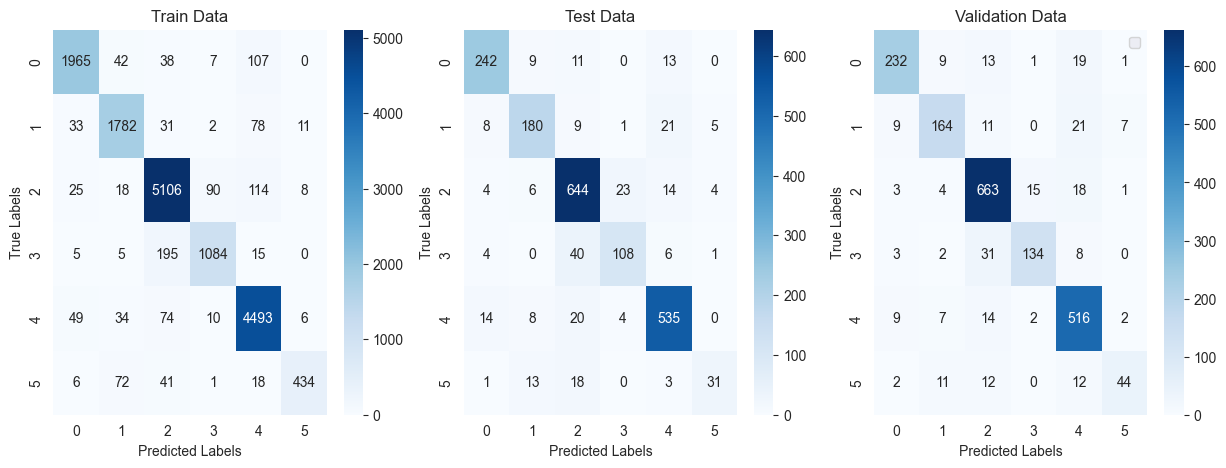

In [164]:
conf_mat(
    oneVall, train_x_train_processed, test_x_test_processed, validation_x_val_processed
)

In [165]:
# Random Forest Classifier

"""
    Steps of model
    1. Text Processing
    2. Vectorization by using CountVectorizer for converting the text to numbers
    3. Training the model by using Pipeline
"""

text_processing_odj = text_processing(
    lower=True,
    remove_special_characters=True,
    remove_punctuation=True,
    remove_stop_words=True,
    stem_the_words=False,
)

RFC = RandomForestClassifier(
    n_estimators=50, random_state=42, n_jobs=-1, verbose=1
)
tdidf = CountVectorizer(max_features=3000)
RFC_pipeline = Pipeline(
    [
        ("text_processing", text_processing_odj),
        ("vectorizer", tdidf),
        ("RFC", RFC),
    ]
)
RFC_pipeline.fit(train_x_train, train_y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


Pipeline(steps=[('text_processing',
                 text_processing(lower=True, remove_punctuation=True,
                                 remove_special_characters=True,
                                 remove_stop_words=True)),
                ('vectorizer', CountVectorizer(max_features=3000)),
                ('RFC',
                 RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                        random_state=42, verbose=1))])

In [166]:
process_pip = Pipeline(
    [
        ("text_processing", text_processing_odj),
    ]
)
train_x_train_processed = process_pip.fit_transform(train_x_train)
test_x_test_processed = process_pip.transform(test_x_test)
validation_x_val_processed = process_pip.transform(validation_x_val)


In [167]:
# validation by using the accuracy score, confusion matrix, and classification report

print(acc_score(train_y_train, RFC_pipeline.predict(train_x_train_processed)))
print(acc_score(test_y_test, RFC_pipeline.predict(test_x_test_processed)))
print(acc_score(validation_y_val, RFC_pipeline.predict(validation_x_val_processed)))

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


0.9971248203012688


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


0.879
0.89


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done  50 out of  50 | elapsed:    0.0s finished
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


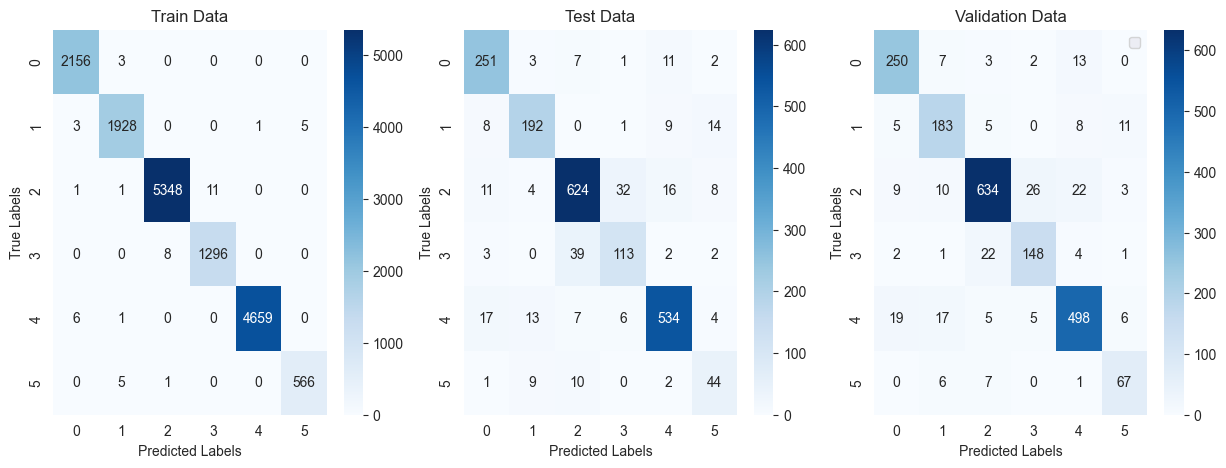

In [168]:
conf_mat(
    RFC_pipeline, train_x_train_processed, test_x_test_processed, validation_x_val_processed
)

In [169]:
# XGBClassifier
"""
        Steps of model
        1. Text Processing
        2. Vectorization by using TfidfVectorizer for converting the text to numbers
        3. Training the model by using Pipeline
"""
    
text_processing_odj = text_processing(
    lower=True,
    remove_special_characters=True,
    remove_punctuation=True,
    remove_stop_words=True,
    stem_the_words=False,
)

xgbc = XGBClassifier(
    n_estimators=50, random_state=42, n_jobs=-1, verbose=1
)
tdidf = TfidfVectorizer(max_features=3000)
xgbc_pipeline = Pipeline(
    [
        ("text_processing", text_processing_odj),
        ("vectorizer", tdidf),
        ("xgbc", xgbc),
    ]
)
xgbc_pipeline.fit(train_x_train, train_y_train)

Pipeline(steps=[('text_processing',
                 text_processing(lower=True, remove_punctuation=True,
                                 remove_special_characters=True,
                                 remove_stop_words=True)),
                ('vectorizer', TfidfVectorizer(max_features=3000)),
                ('xgbc',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stoppin...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=50, n_jobs=-1,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [170]:
process_pip = Pipeline(
    [
        ("text_processing", text_processing_odj),
    ]
)
train_x_train_processed = process_pip.fit_transform(train_x_train)
test_x_test_processed = process_pip.transform(test_x_test)
validation_x_val_processed = process_pip.transform(validation_x_val)


In [171]:
# validation by using the accuracy score, confusion matrix, and classification report

print(acc_score(train_y_train, xgbc_pipeline.predict(train_x_train_processed)))
print(acc_score(test_y_test, xgbc_pipeline.predict(test_x_test_processed)))
print(acc_score(validation_y_val, xgbc_pipeline.predict(validation_x_val_processed)))

0.9309956872304519
0.8775
0.8775


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


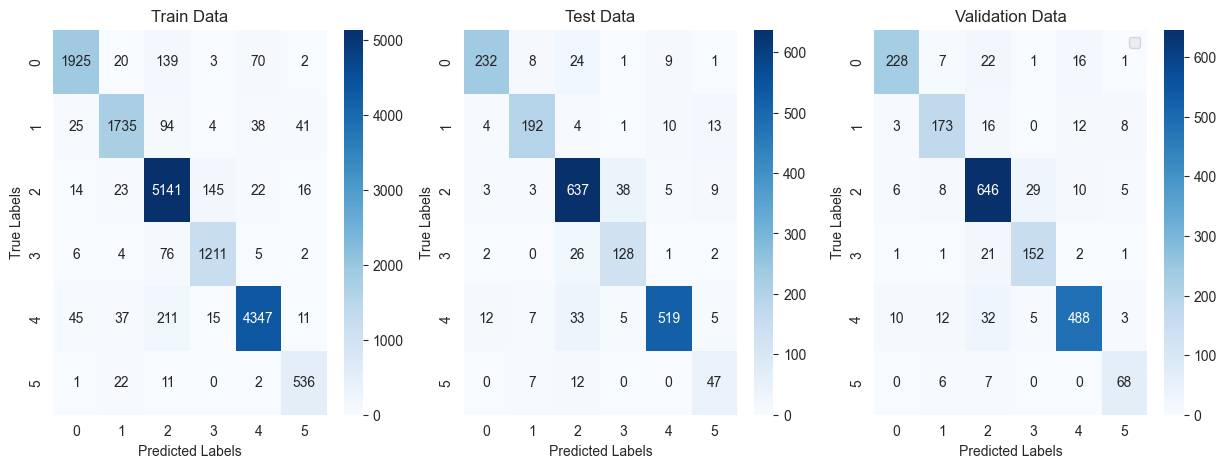

In [172]:
conf_mat(
    xgbc_pipeline, train_x_train_processed, test_x_test_processed, validation_x_val_processed
)

In [173]:
# SVM
"""
        Steps of model
        1. Text Processing
        2. Vectorization by using CountVectorizer for converting the text to numbers
        3. scaling the data by using StandardScaler
        3. Training the model by using Pipeline
"""

text_processing_odj = text_processing(
    lower=True,
    remove_special_characters=True,
    remove_punctuation=True,
    remove_stop_words=True,
    stem_the_words=False,
)
count = CountVectorizer(max_features=3000)
scaler = StandardScaler()
svm = SVC(kernel="linear",gamma=1, C=.5, random_state=42)
svm_pipeline = Pipeline(
    [
        ("text_processing", text_processing_odj),
        ("vectorizer", count),
        #("scaler", scaler),
        ("svm", svm),
    ]
)
svm_pipeline.fit(train_x_train, train_y_train)

Pipeline(steps=[('text_processing',
                 text_processing(lower=True, remove_punctuation=True,
                                 remove_special_characters=True,
                                 remove_stop_words=True)),
                ('vectorizer', CountVectorizer(max_features=3000)),
                ('svm', SVC(C=0.5, gamma=1, kernel='linear', random_state=42))])

In [174]:
process_pip = Pipeline(
    [
        ("text_processing", text_processing_odj),
    ]
)
train_x_train_processed = process_pip.fit_transform(train_x_train)
test_x_test_processed = process_pip.transform(test_x_test)
validation_x_val_processed = process_pip.transform(validation_x_val)


In [175]:
# validation by using the accuracy score, confusion matrix, and classification report

print(acc_score(train_y_train, svm_pipeline.predict(train_x_train_processed)))
print(acc_score(test_y_test, svm_pipeline.predict(test_x_test_processed)))
print(acc_score(validation_y_val, svm_pipeline.predict(validation_x_val_processed)))

0.9680605037814863
0.8825
0.8915


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


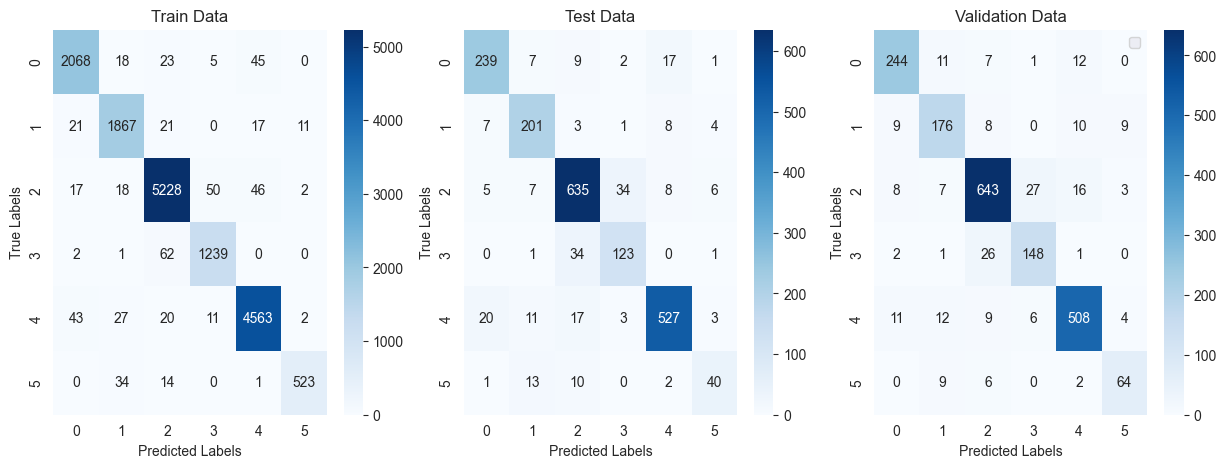

In [176]:
conf_mat(
    svm_pipeline, train_x_train_processed, test_x_test_processed, validation_x_val_processed
)

In [178]:
# voting classifier


vot = VotingClassifier(
    estimators=[
        ("MNB", oneVall),
        ("RFC", RFC_pipeline),
        ("XGB", xgbc_pipeline),
        ("SVM", svm_pipeline),
    ],
)
vot.fit(train_x_train, train_y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.5s finished


VotingClassifier(estimators=[('MNB',
                              OneVsRestClassifier(estimator=Pipeline(steps=[('text_processing',
                                                                             text_processing(lower=True,
                                                                                             remove_special_characters=True)),
                                                                            ('vectorizer',
                                                                             CountVectorizer(max_features=3000)),
                                                                            ('MNB',
                                                                             MultinomialNB())]))),
                             ('RFC',
                              Pipeline(steps=[('text_processing',
                                               text_processing(lower=True,
                                                               remove_punctuation=True,
                                                               remove_special_cha...
                                                             multi_strategy=None,
                                                             n_estimators=50,
                                                             n_jobs=-1,
                                                             num_parallel_tree=None,
                                                             objective='multi:softprob', ...))])),
                             ('SVM',
                              Pipeline(steps=[('text_processing',
                                               text_processing(lower=True,
                                                               remove_punctuation=True,
                                                               remove_special_characters=True,
                                                               remove_stop_words=True)),
                                              ('vectorizer',
                                               CountVectorizer(max_features=3000)),
                                              ('svm',
                                               SVC(C=0.5, gamma=1,
                                                   kernel='linear',
                                                   random_state=42))]))])

In [179]:
process_pip = Pipeline(
    [
        ("text_processing", text_processing_odj),
    ]
)
train_x_train_processed = process_pip.fit_transform(train_x_train)
test_x_test_processed = process_pip.transform(test_x_test)
validation_x_val_processed = process_pip.transform(validation_x_val)


In [180]:
# validation by using the accuracy score, confusion matrix, and classification report

print(acc_score(train_y_train, svm_pipeline.predict(train_x_train_processed)))
print(acc_score(test_y_test, svm_pipeline.predict(test_x_test_processed)))
print(acc_score(validation_y_val, svm_pipeline.predict(validation_x_val_processed)))

0.9680605037814863
0.8825
0.8915
